#Volatility Modelling and Portfolio Optimization

In [7]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 12.4 MB/s eta 0:00:00


In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [61]:
# Define tickers for the selected assets
tickers = ['AAPL', 'PFE', 'CVX', 'BAC']

data = yf.download(tickers, start="2010-01-01", end="2023-01-01")['Adj Close']

print("Historical Price Data:")
print(data.head())

# # Save data to CSV (optional)
# data.to_csv("selected_assets_prices.csv")


[*********************100%***********************]  4 of 4 completed

Historical Price Data:
Ticker          AAPL        BAC        CVX        PFE
Date                                                 
2010-01-04  6.447410  12.451035  44.045532  10.031841
2010-01-05  6.458558  12.855752  44.357533   9.888753
2010-01-06  6.355825  13.006535  44.363087   9.856957
2010-01-07  6.344078  13.435055  44.195957   9.819860
2010-01-08  6.386254  13.316019  44.273941   9.899353


In [62]:
returns=data.pct_change().dropna()

print("Daily Returns:")
print(returns.head())

Daily Returns:
Ticker          AAPL       BAC       CVX       PFE
Date                                              
2010-01-05  0.001729  0.032505  0.007084 -0.014263
2010-01-06 -0.015907  0.011729  0.000125 -0.003215
2010-01-07 -0.001848  0.032947 -0.003767 -0.003764
2010-01-08  0.006648 -0.008860  0.001765  0.008095
2010-01-11 -0.008821  0.008939  0.017743  0.008030


In [63]:
# Mean returns (annualized if needed)
mean_returns = returns.mean() * 252  # Assuming 252 trading days in a year

# Volatility (annualized)
volatility = (returns.std() * np.sqrt(252))

# Correlation matrix
correlation_matrix = returns.corr()

# Display the metrics
print("\nMean Annualized Returns:")
print(mean_returns)
print("\nAnnualized Volatility:")
print(volatility)
print("\nCorrelation Matrix:")
print(correlation_matrix)



Mean Annualized Returns:
Ticker
AAPL    0.271930
BAC     0.131541
CVX     0.140924
PFE     0.140809
dtype: float64

Annualized Volatility:
Ticker
AAPL    0.287158
BAC     0.347598
CVX     0.275266
PFE     0.215403
dtype: float64

Correlation Matrix:
Ticker      AAPL       BAC       CVX       PFE
Ticker                                        
AAPL    1.000000  0.399665  0.360417  0.327071
BAC     0.399665  1.000000  0.555621  0.391945
CVX     0.360417  0.555621  1.000000  0.375691
PFE     0.327071  0.391945  0.375691  1.000000


In [64]:
# Calculate log returns for all assets
log_returns = np.log(data / data.shift(1)).dropna()

print("\nLog Returns for All Assets:")
print(log_returns.head())



Log Returns for All Assets:
Ticker          AAPL       BAC       CVX       PFE
Date                                              
2010-01-05  0.001728  0.031988  0.007059 -0.014366
2010-01-06 -0.016034  0.011661  0.000125 -0.003220
2010-01-07 -0.001850  0.032415 -0.003774 -0.003771
2010-01-08  0.006626 -0.008900  0.001763  0.008063
2010-01-11 -0.008860  0.008900  0.017587  0.007998


##Volatility Modelling using GARCH Model

In [65]:
# Function to fit GARCH models and return results for a single asset
def fit_garch_models(returns, max_p=2, max_q=2):
    results = []

    for p in range(1, max_p + 1):  # Iterate over p values
        for q in range(1, max_q + 1):  # Iterate over q values
            try:
                # Fit GARCH(p, q)
                model = arch_model(returns, vol='Garch', p=p, q=q)
                fit = model.fit(disp="off")

                # Append results
                results.append({
                    'p': p, 'q': q,
                    'AIC': fit.aic, 'BIC': fit.bic
                })
            except Exception as e:
                # Handle cases where model fitting fails
                print(f"Failed for p={p}, q={q}: {e}")

    results_df = pd.DataFrame(results)
    return results_df



Fitting GARCH models for AAPL...
Best model for AAPL based on AIC: p          1.000000
q          1.000000
AIC    12656.377013
BIC    12680.748417
Name: 0, dtype: float64
Best model for AAPL based on BIC: p          1.000000
q          1.000000
AIC    12656.377013
BIC    12680.748417
Name: 0, dtype: float64


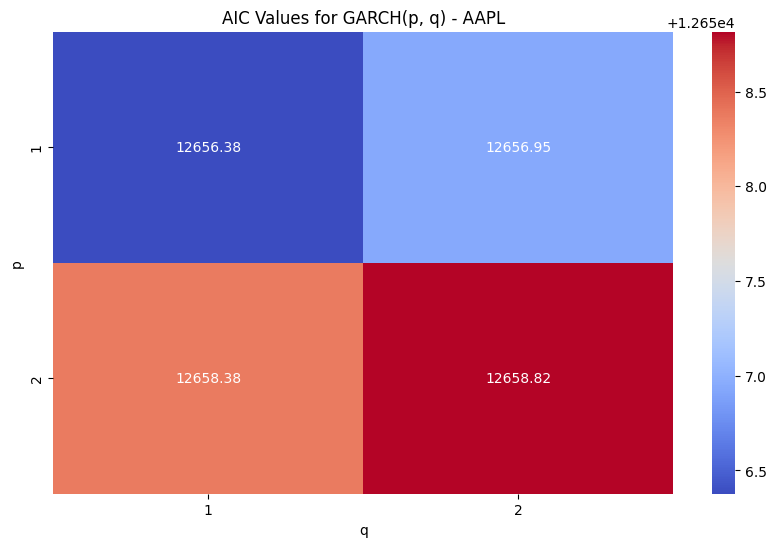

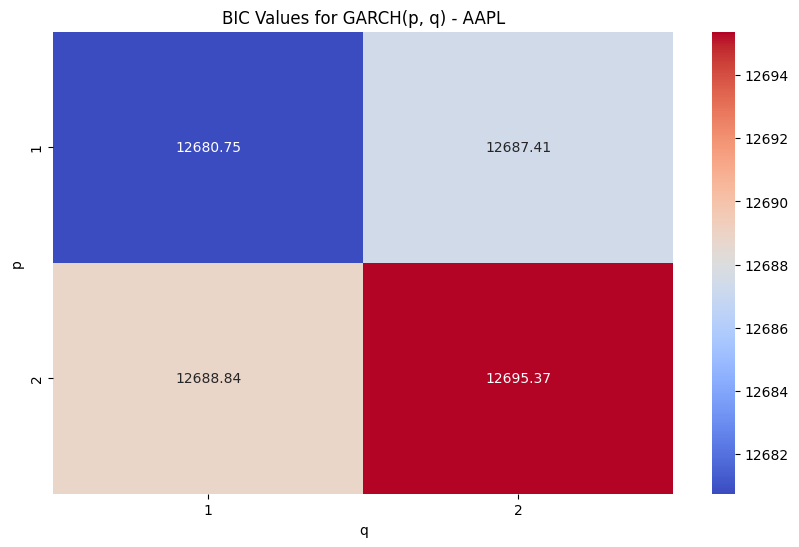


Fitting GARCH models for BAC...
Best model for BAC based on AIC: p          1.000000
q          2.000000
AIC    13356.101725
BIC    13386.565980
Name: 1, dtype: float64
Best model for BAC based on BIC: p          1.000000
q          1.000000
AIC    13356.741495
BIC    13381.112899
Name: 0, dtype: float64


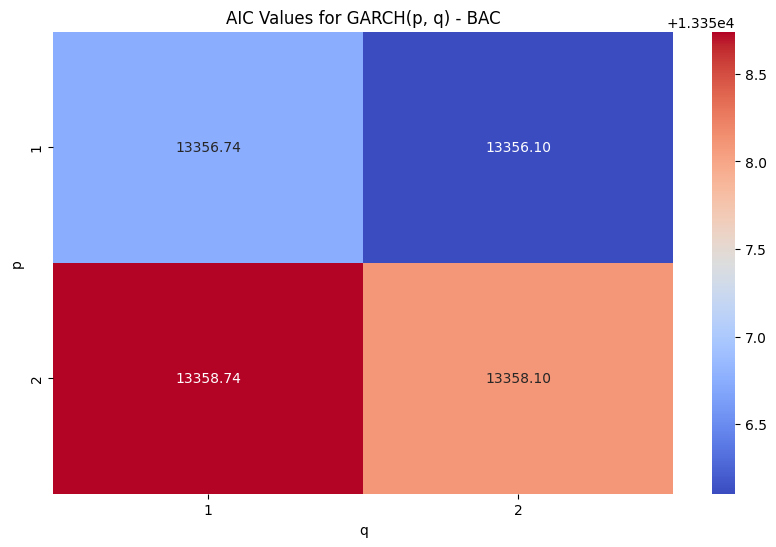

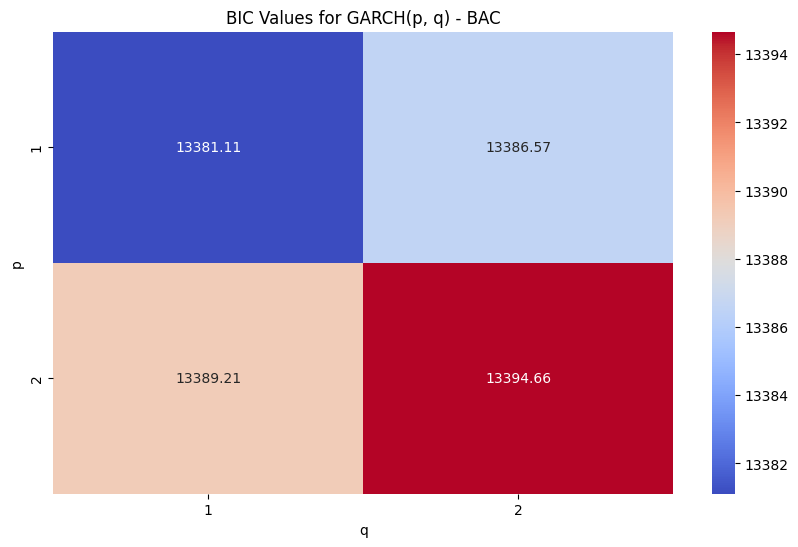


Fitting GARCH models for CVX...
Best model for CVX based on AIC: p          2.000000
q          1.000000
AIC    11495.042040
BIC    11525.506296
Name: 2, dtype: float64
Best model for CVX based on BIC: p          1.000000
q          1.000000
AIC    11495.582926
BIC    11519.954330
Name: 0, dtype: float64


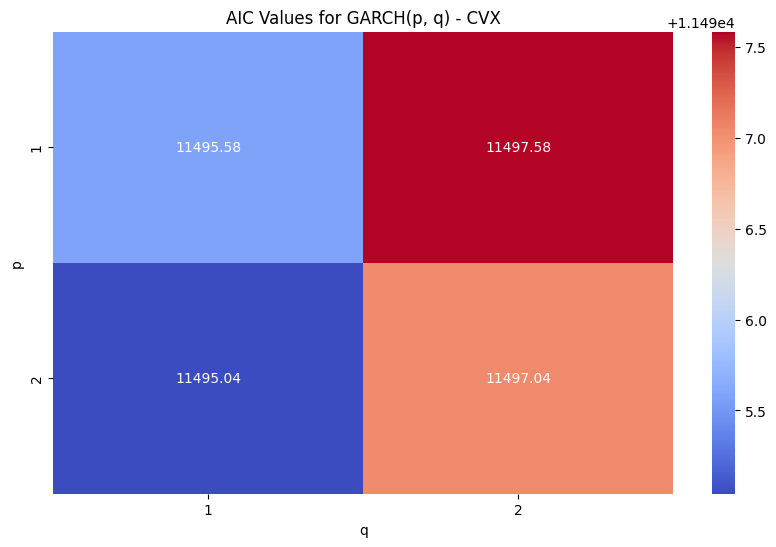

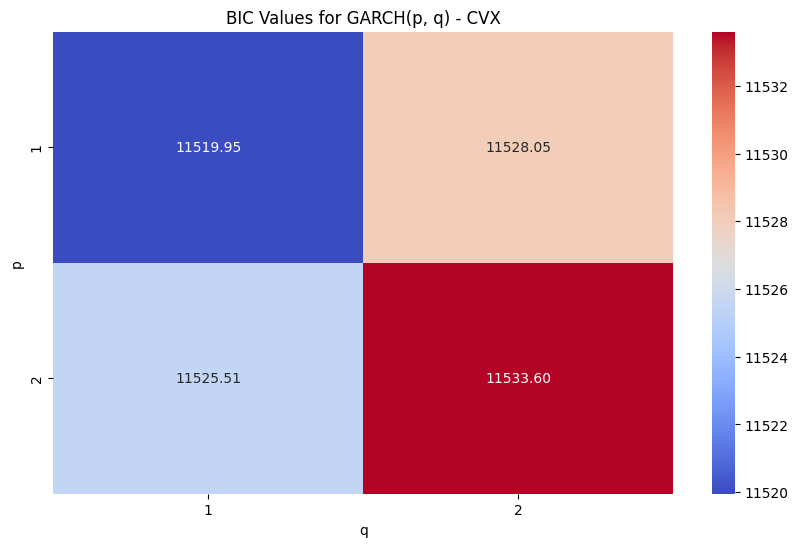


Fitting GARCH models for PFE...
Best model for PFE based on AIC: p          1.000000
q          1.000000
AIC    10529.972424
BIC    10554.343828
Name: 0, dtype: float64
Best model for PFE based on BIC: p          1.000000
q          1.000000
AIC    10529.972424
BIC    10554.343828
Name: 0, dtype: float64


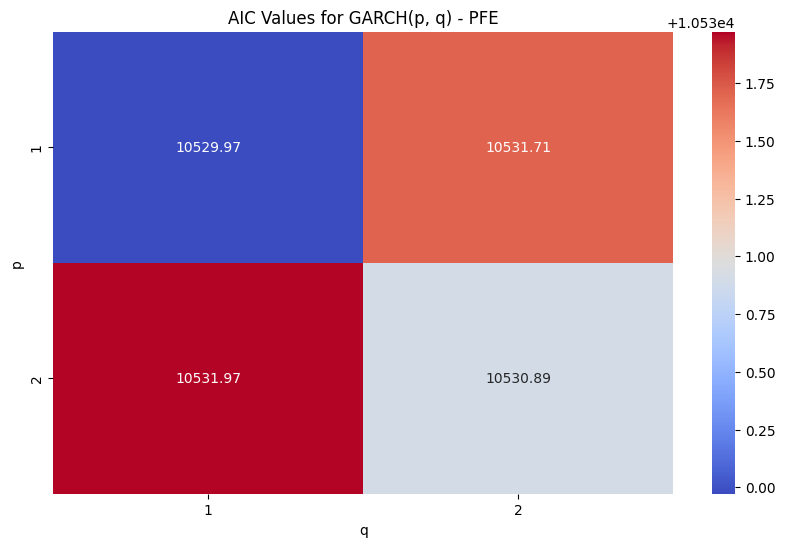

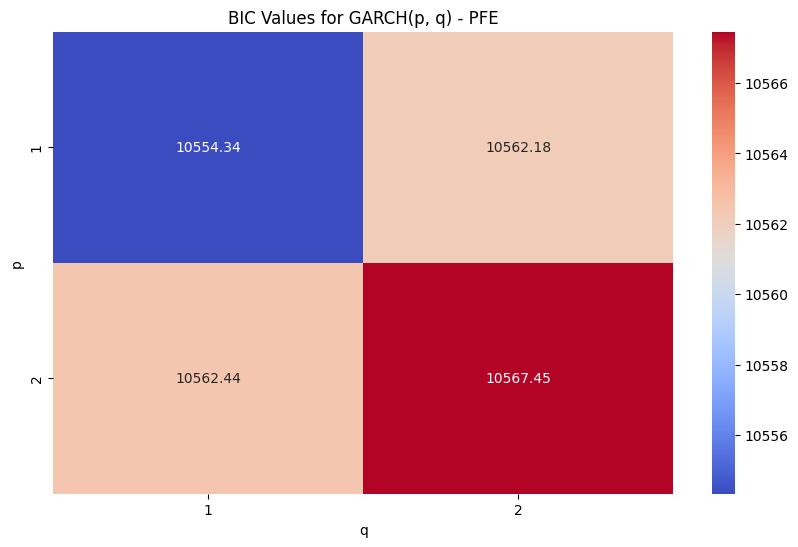

In [66]:
# Fit GARCH models for each asset and store the results
all_results = {}
for asset in log_returns.columns:
    print(f"\nFitting GARCH models for {asset}...")
    results_df = fit_garch_models(log_returns[asset] * 100)  # Scale returns

    all_results[asset] = results_df

    # Find and print the best model based on AIC and BIC
    best_model_aic = results_df.loc[results_df['AIC'].idxmin()]
    best_model_bic = results_df.loc[results_df['BIC'].idxmin()]
    print(f"Best model for {asset} based on AIC: {best_model_aic}")
    print(f"Best model for {asset} based on BIC: {best_model_bic}")

    # Plot AIC and BIC heatmaps
    plt.figure(figsize=(10, 6))
    sns.heatmap(results_df.pivot(index='p', columns='q', values='AIC'), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'AIC Values for GARCH(p, q) - {asset}')
    plt.xlabel('q')
    plt.ylabel('p')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(results_df.pivot(index='p', columns='q', values='BIC'), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'BIC Values for GARCH(p, q) - {asset}')
    plt.xlabel('q')
    plt.ylabel('p')
    plt.show()



In [69]:
# Fit the best model and predict volatility for each asset
conditional_volatilities = {}
for asset in log_returns.columns:
    print(f"\nFitting the final GARCH model for {asset}...")
    results_df = all_results[asset]

    # Get the best (p, q) based on AIC
    best_p, best_q = int(results_df.loc[results_df['AIC'].idxmin()]['p']), int(results_df.loc[results_df['AIC'].idxmin()]['q'])

    # Fit the best model
    model = arch_model(log_returns[asset]*100, vol='Garch', p=best_p, q=best_q)
    final_fit = model.fit(disp="off")

    # Predict conditional volatility
    forecast = final_fit.forecast(horizon=1, reindex=False)
    conditional_volatility = np.sqrt(forecast.variance.iloc[-1, 0])
    conditional_volatilities[asset] = conditional_volatility

    print(f"Conditional volatility for {asset}: {conditional_volatility:.4f}")



Fitting the final GARCH model for AAPL...
Conditional volatility for AAPL: 2.0290

Fitting the final GARCH model for BAC...
Conditional volatility for BAC: 1.3724

Fitting the final GARCH model for CVX...
Conditional volatility for CVX: 1.5731

Fitting the final GARCH model for PFE...
Conditional volatility for PFE: 1.2852


In [70]:
std_devs = np.array(list(conditional_volatilities.values()))
std_devs = std_devs*np.sqrt(252)/100 # Annualize standard deviations
covariance_matrix = np.outer(std_devs, std_devs) * correlation_matrix

print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
Ticker      AAPL       BAC       CVX       PFE
Ticker                                        
AAPL    0.103749  0.028045  0.028990  0.021493
BAC     0.028045  0.047460  0.030227  0.017420
CVX     0.028990  0.030227  0.062361  0.019140
PFE     0.021493  0.017420  0.019140  0.041621


##Optimize based on Risk

In [71]:
# Step 2: Portfolio Optimization (Minimizing Risk)
num_assets = len(conditional_volatilities)

def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1) for _ in range(num_assets)]  # Long-only portfolio
initial_weights = np.array([1 / num_assets] * num_assets)

opt_result = minimize(
    portfolio_variance,
    initial_weights,
    args=(covariance_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights_risk = opt_result.x
portfolio_risk = np.sqrt(opt_result.fun)

print("\nOptimal Portfolio Weights (Minimizing Risk):")
print(optimal_weights_risk)
print(f"Portfolio Risk (Standard Deviation): {portfolio_risk}")


Optimal Portfolio Weights (Minimizing Risk):
[0.0585632  0.31235432 0.147205   0.48187749]
Portfolio Risk (Standard Deviation): 0.17169801894364908


##Optimize for Sharpe Ratio

In [72]:
# Objective: Maximize the Sharpe ratio (maximize return per unit of risk)
def neg_sharpe_ratio(weights, covariance_matrix, expected_returns):
    # Portfolio expected return (weighted sum of individual asset returns)
    portfolio_return = np.dot(weights, expected_returns)

    # Portfolio risk (standard deviation)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

    # Sharpe ratio (return / risk) - we minimize negative Sharpe ratio
    return -portfolio_return / portfolio_std

# Perform optimization to maximize Sharpe ratio
opt_result_sr = minimize(
    neg_sharpe_ratio,
    initial_weights,
    args=(covariance_matrix, list(mean_returns)),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)


In [73]:
# Optimal portfolio weights (allocation across assets)
optimal_weights_sr = opt_result_sr.x
print("Optimal Weights for Maximizing Sharpe Ratio:")
print(optimal_weights_sr)

# Portfolio expected return
portfolio_return = np.dot(optimal_weights_sr,list(mean_returns))

# Portfolio risk (standard deviation)
portfolio_std = np.sqrt(np.dot(optimal_weights_sr.T, np.dot(covariance_matrix, optimal_weights_sr)))

# Sharpe ratio
sharpe_ratio = portfolio_return / portfolio_std
print(f"Portfolio Expected Return: {portfolio_return}")
print(f"Portfolio Standard Deviation: {portfolio_std}")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio}")

Optimal Weights for Maximizing Sharpe Ratio:
[0.38954971 0.12925526 0.09519381 0.38600122]
Portfolio Expected Return: 0.1907000114933173
Portfolio Standard Deviation: 0.1965442472828489
Portfolio Sharpe Ratio: 0.9702650376679757
